# Time serie forecasting

This notebook is an attempt to use LSTM for time series forecasting. I start with the Lorentz attractor as a toy example, as in Hsu, Daniel. "Time Series Forecasting Based on Augmented Long Short-Term Memory." arXiv preprint arXiv:1707.00666 (2017).

### Lorenz time serie

First, we generate a Lorenz time serie using a standard ode solver:

In [46]:
import numpy as np
from scipy.integrate import ode

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

def Lorenz_func(t,y, sigma = 10., rho = 28., beta = 8./3.):
    f = np.zeros_like(y)
    f[0] = sigma*(y[1]-y[0])
    f[1] = rho*y[0]-y[1]-y[0]*y[2]
    f[2] = y[0]*y[1] - beta*y[2]
    return f

def normalize(x):
    return (x-x.mean())/x.std()

In [27]:
y0 = np.random.standard_normal((3,))
t0,t1 = 0.,10000.
t = np.linspace(t0,t1,int(1e6))
dt = t[1]-t[0]
r = ode(Lorenz_func)
r.set_initial_value(y0, t0);

i=0
y = np.zeros([t.size,3])
y[0,:] = y0
while r.successful() and i < t.size-1:
    r.integrate(r.t+dt)
    y[i+1,:] = r.y
    i+=1

y[:,0] = normalize(y[:,0])
y[:,1] = normalize(y[:,1])
y[:,2] = normalize(y[:,2])

In [28]:
y_Lorenz = y

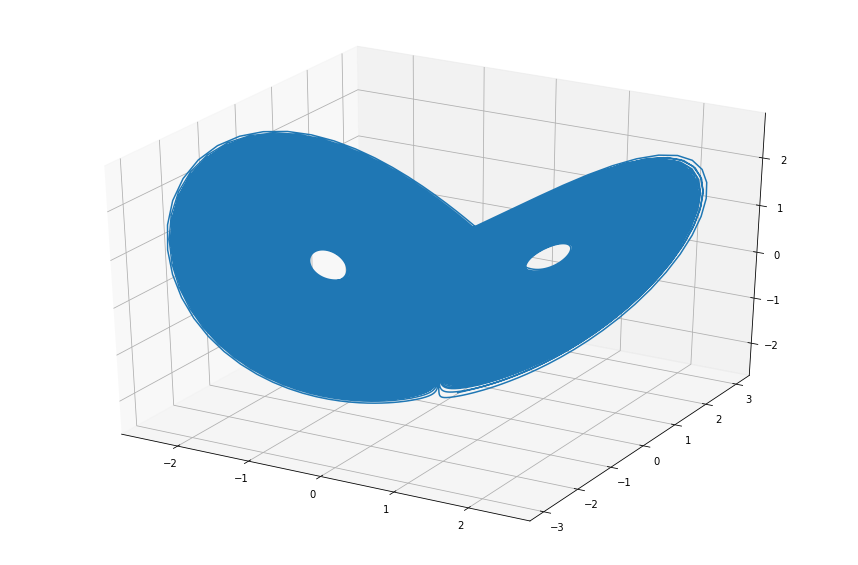

In [135]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,10));
ax = fig.add_subplot(111, projection='3d');
ax.plot(y[:,0],y[:,1],zs = y[:,2]);

# Convolutional forecasting model

In [5]:
import tensorflow as tf
import numpy as np
from random import shuffle

import keras

from keras import regularizers

from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Input, Reshape, Lambda
from keras.layers import LSTM

from keras.models import Model, Sequential

from keras.optimizers import Adam

/home/peter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/peter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [53]:
input_length = 100
input_dim = 3
output_length = 50
output_dim = 3
def generate_batch(x, N_batch = 5000):
    init = np.random.randint(x.shape[0]-input_length-output_length, size = N_batch)
    train_data = np.zeros([N_batch, input_length, input_dim])
    y_true = np.zeros([N_batch, output_length, output_dim])
    for i in range(N_batch):
        z = x[init[i]:init[i]+input_length+output_length,:]
        train_data[i,:] = z[:input_length,:]
        y_true[i,:] = z[input_length:,:]
#         y_true[i,:] = np.diff(z[input_length-1:,:])
    return (train_data, y_true)

I use a fairly simple architecture: I start with a few convolutional layers on the sequence to extract relevant features, feed the feature time serie into the LSTM, then interpret the final hidden state as a feature sequence which is then decoded by a few more convolution layers.

In [112]:
inputs = Input(shape=(input_length,input_dim))

num_filters = 32
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           activation = 'relu')(inputs)
num_filters = 32
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)

lstm_output_dim = 8
units = output_length*lstm_output_dim
x = LSTM(units, activation = 'tanh', return_sequences = False)(x)

x = Reshape((output_length, lstm_output_dim))(x)
num_filters = 8
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = 64
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = output_dim
kernel_size = 1
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = None)(x)

predictor = Model(inputs = inputs, outputs = x)
predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100, 3)            0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 98, 32)            320       
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 48, 32)            3104      
_________________________________________________________________
lstm_9 (LSTM)                (None, 400)               692800    
_________________________________________________________________
reshape_10 (Reshape)         (None, 50, 8)             0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 50, 8)             200       
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 50, 64)            1600      
__________

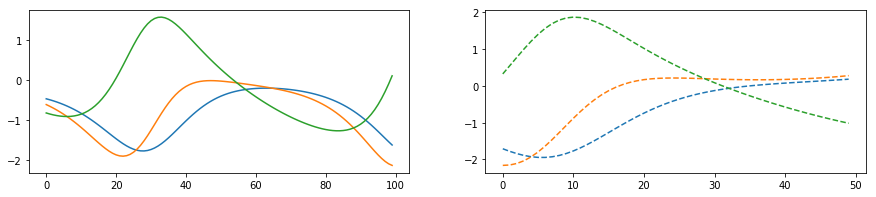

In [113]:
# set aside some data for testing
test = y[-int(1e4):]
# generate a batch
batch = generate_batch(y[:-int(1e4)])
# plot an example of sequence data and expected predictions
x_train, y_true = batch
f, ax = plt.subplots(1, 2, squeeze=False, figsize = (15,3))
ax[0,0].plot(x_train[0,:,:].squeeze());
ax[0,1].plot(y_true[0,:,:].squeeze(),'--');

I have a hard time deciding between training via mean absolute error (a fairly usual error metric in time serie forecasting apparently) and mean squared error, which is a more usual error function across domains. So I alternate between the two.

Usually I'd keep the same learning rate between two training bouts, but the mean absolute error has the peculiar feature that it's profile is sharp: the gradient doesn't naturally decrease when you get closer to perfect fit, meaning it requires a lower learning rate at a given stage than the mean squared error. On the other hand by the time I start training with MSE we're closer to the minimum, at which point we'd usually reduce the learning rate. I assume these two effects cancel out. The schedule below is basically an interation of this (I haven't optimized it much):

In [17]:
def train(predictor, learning_rate, batch, 
          beta=0.9, epochs = 10, initial = 0, 
          callbacks = [keras.callbacks.ReduceLROnPlateau(verbose=1, patience = 1, factor = .1),] ):
    
    x_train, y_true = batch
    
    lr = learning_rate
    beta = 0.9
    loss = 'mean_absolute_error'
    optimizer = Adam(lr,beta)
    predictor.compile(loss = loss, optimizer = optimizer)
    
    initial_epoch = initial
    num_epochs = initial_epoch + epochs
    hist0 = predictor.fit(x_train, y_true, epochs = num_epochs, initial_epoch = initial_epoch, callbacks = callbacks, validation_split = .1)

    lr = learning_rate
    beta = 0.9
    loss = 'mean_squared_error'
    optimizer = Adam(lr,beta)
    predictor.compile(loss = loss, optimizer = optimizer)

    initial_epoch = num_epochs
    num_epochs = initial_epoch + epochs
    hist1 = predictor.fit(x_train, y_true, epochs = num_epochs, initial_epoch = initial_epoch, callbacks = callbacks, validation_split = .1)
    return hist0, hist1

In [114]:
hist0 = train(predictor, 1e-2, batch, epochs = 30)
hist1 = train(predictor, 1e-4, batch, epochs = 10)
hist2 = train(predictor, 1e-5, batch, epochs = 10)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 9s - loss: 0.3468 - val_loss: 0.1918
Epoch 2/30
4500/4500 [==============================] - 7s - loss: 0.1676 - val_loss: 0.1495
Epoch 3/30
4500/4500 [==============================] - 7s - loss: 0.1367 - val_loss: 0.1520
Epoch 4/30
4500/4500 [==============================] - 7s - loss: 0.1268 - val_loss: 0.1337
Epoch 5/30
4500/4500 [==============================] - 7s - loss: 0.1137 - val_loss: 0.1109
Epoch 6/30
4500/4500 [==============================] - 7s - loss: 0.1036 - val_loss: 0.1026ss: 0.1
Epoch 7/30
4500/4500 [==============================] - 7s - loss: 0.0995 - val_loss: 0.0867
Epoch 8/30
4500/4500 [==============================] - 7s - loss: 0.0987 - val_loss: 0.1042
Epoch 9/30
4480/4500 [============================>.] - ETA: 0s - loss: 0.0981
Epoch 00008: reducing learning rate to 0.0009999999776482583.
4500/4500 [==============================] - 8s - loss: 0.098

4500/4500 [==============================] - 9s - loss: 0.0017 - val_loss: 0.0018
Epoch 12/20
4500/4500 [==============================] - 7s - loss: 0.0017 - val_loss: 0.0018
Epoch 13/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00012: reducing learning rate to 9.999999747378752e-06.
4500/4500 [==============================] - 9s - loss: 0.0016 - val_loss: 0.0018
Epoch 14/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00013: reducing learning rate to 9.999999747378752e-07.
4500/4500 [==============================] - 7s - loss: 0.0016 - val_loss: 0.0018
Epoch 15/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00014: reducing learning rate to 9.999999974752428e-08.
4500/4500 [==============================] - 7s - loss: 0.0016 - val_loss: 0.0018
Epoch 16/20
4480/4500 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00015: reducing learning rate to 1.0000000116860975e-08.
4500/4500

The end MSE error is 0.0017, which gives a RMSE of 0.04 - slightly worse worse than the paper (which reached around 0.02), but the model is, as far as I know, very different from the original paper aside from the presence of a LSTM cell (for example, the training sequence is 100 instead of 1000).

In [66]:
# let's give the model something with a more innocuous name to avoid overwriting it
pred_0 = keras.models.clone_model(predictor)
pred_0.set_weights(predictor.get_weights())

In [122]:
i=np.random.randint(test.shape[0]-(input_length+output_length))
x_test = test[i:i+input_length+output_length,:]
# y_test = np.diff(x_test[-(output_length+1):,:],axis=0)
y_test = x_test[-(output_length):,:]
x_test = x_test[:-output_length,:]
y_pred = pred_0.predict(np.expand_dims(x_test, axis=0)).squeeze()

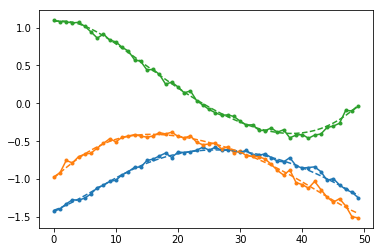

In [123]:
plt.plot(range(output_length),y_pred.squeeze(),'.-');
plt.gca().set_prop_cycle(None);
plt.plot(range(output_length), y_test,'--');

Let's try a different architecture with a sharper reduction in the temporal dimension:

In [14]:
inputs = Input(shape=(input_length,input_dim))

# feature selection
num_filters = 32
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           activation = 'relu')(inputs)
num_filters = 64
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)
num_filters = 128
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)
num_filters = 256
kernel_size = 3
strides = 2
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, 
           strides = strides,
           activation = 'relu')(x)

# lstm unit
lstm_output_dim = 8
units = output_length*lstm_output_dim
x = LSTM(units, activation = 'tanh', return_sequences = False)(x)

# interpreting the output
x = Reshape((output_length, lstm_output_dim))(x)
num_filters = 8
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = 64
kernel_size = 3
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = 'relu')(x)
num_filters = output_dim
kernel_size = 1
x = Conv1D(filters=num_filters, 
            kernel_size = kernel_size, padding='same',
           activation = None)(x)

predictor = Model(inputs = inputs, outputs = x)
predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 98, 32)            320       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 48, 64)            6208      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 23, 128)           24704     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 11, 256)           98560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1051200   
_________________________________________________________________
reshape_2 (Reshape)          (None, 50, 8)             0         
__________

The model has twice as many parameters, but the LSTM only unrolls on a sequence of length 11 instead of 49, so it should be faster to train.

In [18]:
# set aside some data for testing
test = y[-int(1e4):]
# generate a batch
batch = generate_batch(y[:-int(1e4)])

hist0 = train(predictor, 1e-2, batch, epochs = 30)
hist1 = train(predictor, 1e-4, batch, epochs = 10)
hist2 = train(predictor, 1e-5, batch, epochs = 10)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 9s - loss: 0.5185 - val_loss: 0.3079
Epoch 2/30
4500/4500 [==============================] - 2s - loss: 0.2076 - val_loss: 0.1682
Epoch 3/30
4500/4500 [==============================] - 2s - loss: 0.1643 - val_loss: 0.1528
Epoch 4/30
4500/4500 [==============================] - 2s - loss: 0.1378 - val_loss: 0.1368
Epoch 5/30
4500/4500 [==============================] - 2s - loss: 0.1314 - val_loss: 0.1369
Epoch 6/30
4448/4500 [============================>.] - ETA: 0s - loss: 0.1204
Epoch 00005: reducing learning rate to 0.0009999999776482583.
4500/4500 [==============================] - 2s - loss: 0.1205 - val_loss: 0.1371
Epoch 7/30
4500/4500 [==============================] - 2s - loss: 0.0890 - val_loss: 0.0855
Epoch 8/30
4500/4500 [==============================] - 2s - loss: 0.0778 - val_loss: 0.0799
Epoch 9/30
4500/4500 [==============================] - 2s - loss: 0.0735 - val

In [19]:
# let's give the model something with a more innocuous name to avoid overwriting it
pred_1 = keras.models.clone_model(predictor)
pred_1.set_weights(predictor.get_weights())

In [129]:
i=np.random.randint(test.shape[0]-(input_length+output_length))
x_test = test[i:i+input_length+output_length,:]
y_test = x_test[-(output_length):,:]
x_test = x_test[:-output_length,:]
y_pred = pred_1.predict(np.expand_dims(x_test,axis=0)).squeeze()

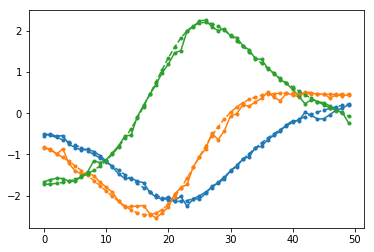

In [130]:
plt.plot(range(output_length),y_pred.squeeze(),'.-');
plt.gca().set_prop_cycle(None);
plt.plot(range(output_length), y_test,'.--');

Slightly worse than the previous version, but not bad for something that's more than twice as fast!

### Testing on the Rossler Time Series

The Rossler time series is another serie used as a benchmark in the paper. As with Lorenz, it is obtained from solving a differential equation.

In [1]:
def Rossler(t,y, a=.2, b=.2, c=4.6):
    f = np.zeros_like(y)
    f[0] = -y[1]-y[2]
    f[1] = y[0]+a*y[1]
    f[2] = b + y[2]*(y[0]-c)
    return f

In [29]:
y0 = np.random.standard_normal((3,))
t0,t1 = 0.,10000.
t = np.linspace(t0,t1,int(1e6))
dt = t[1]-t[0]
r = ode(Rossler)
r.set_initial_value(y0, t0);

i=0
y = np.zeros([t.size,3])
y[0,:] = y0
while r.successful() and i < t.size-1:
    r.integrate(r.t+dt)
    y[i+1,:] = r.y
    i+=1

y[:,0] = normalize(y[:,0])
y[:,1] = normalize(y[:,1])
y[:,2] = normalize(y[:,2])
y_Rossler = y

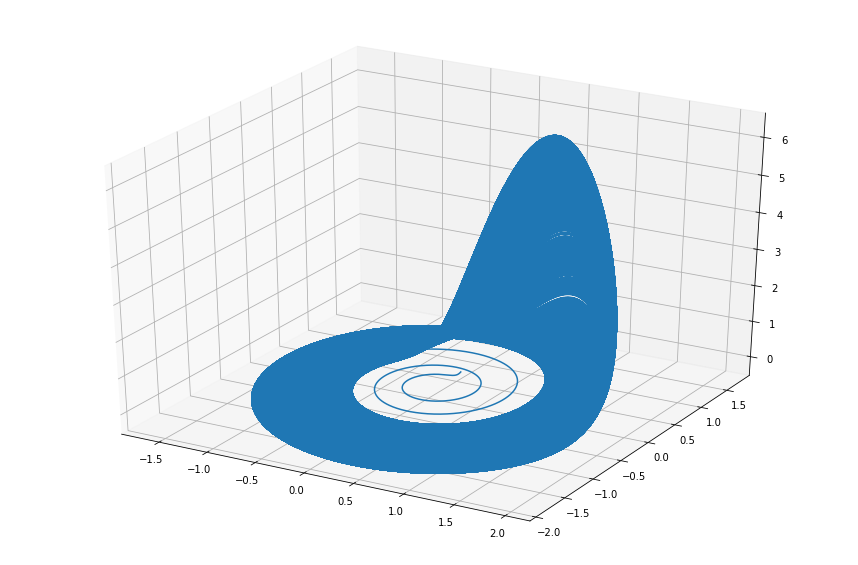

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,10));
ax = fig.add_subplot(111, projection='3d');
ax.plot(y[:,0],y[:,1],zs = y[:,2]);

Let's train a the fast model on the new data:

In [36]:
# set aside some data for testing
test_Rossler = y_Rossler[-N_test:]
# generate a batch
batch_Rossler = generate_batch(y_Rossler[:-N_test])

hist0 = train(predictor, 1e-2, batch_Rossler, epochs = 30)
hist1 = train(predictor, 1e-4, batch_Rossler, epochs = 10)
hist2 = train(predictor, 1e-5, batch_Rossler, epochs = 10)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 3s - loss: 0.3979 - val_loss: 0.2382
Epoch 2/30
4500/4500 [==============================] - 2s - loss: 0.1994 - val_loss: 0.1632
Epoch 3/30
4500/4500 [==============================] - 2s - loss: 0.1483 - val_loss: 0.1327
Epoch 4/30
4500/4500 [==============================] - 2s - loss: 0.1323 - val_loss: 0.1208
Epoch 5/30
4500/4500 [==============================] - 2s - loss: 0.1104 - val_loss: 0.1115
Epoch 6/30
4500/4500 [==============================] - 2s - loss: 0.1028 - val_loss: 0.1039
Epoch 7/30
4500/4500 [==============================] - 2s - loss: 0.0951 - val_loss: 0.0942
Epoch 8/30
4500/4500 [==============================] - 2s - loss: 0.0949 - val_loss: 0.0807
Epoch 9/30
4500/4500 [==============================] - 2s - loss: 0.0879 - val_loss: 0.0822
Epoch 10/30
4416/4500 [============================>.] - ETA: 0s - loss: 0.0886
Epoch 00009: reducing learning rate 

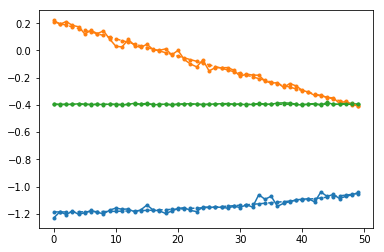

In [37]:
i=np.random.randint(test_Rossler.shape[0]-(input_length+output_length))
x_test = test_Rossler[i:i+input_length+output_length,:]
y_test = x_test[-(output_length):,:]
x_test = x_test[:-output_length,:]
y_pred = predictor.predict(np.expand_dims(x_test,axis=0)).squeeze()

plt.plot(range(output_length),y_pred.squeeze(),'.-');
plt.gca().set_prop_cycle(None);
plt.plot(range(output_length), y_test,'.--');

In [38]:
# let's give the model something with a more innocuous name to avoid overwriting it
pred_Rossler = keras.models.clone_model(predictor)
pred_Rossler.set_weights(predictor.get_weights())

One issue is that as we can see from the plots, not much is happening over a standard time period. So let's shrink time a little bit:

In [62]:
y_Rossler_fast = y_Rossler[::10,:]

In [67]:
N_test_fast = int(1e3)
# set aside some data for testing
test_Rossler_fast = y_Rossler_fast[-N_test_fast:,:]
# generate a batch
batch_Rossler_fast = generate_batch(y_Rossler_fast[:-N_test_fast,:])

hist0 = train(predictor, 1e-2, batch_Rossler_fast, epochs = 30)
hist1 = train(predictor, 1e-4, batch_Rossler_fast, epochs = 10)
hist2 = train(predictor, 1e-5, batch_Rossler_fast, epochs = 10)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 3s - loss: 0.3129 - val_loss: 0.1849
Epoch 2/30
4500/4500 [==============================] - 2s - loss: 0.1496 - val_loss: 0.1394
Epoch 3/30
4500/4500 [==============================] - 2s - loss: 0.1136 - val_loss: 0.1025
Epoch 4/30
4500/4500 [==============================] - 2s - loss: 0.0995 - val_loss: 0.0922
Epoch 5/30
4500/4500 [==============================] - 2s - loss: 0.0858 - val_loss: 0.1021
Epoch 6/30
4500/4500 [==============================] - 2s - loss: 0.0812 - val_loss: 0.0895
Epoch 7/30
4500/4500 [==============================] - 2s - loss: 0.0813 - val_loss: 0.0933
Epoch 8/30
4500/4500 [==============================] - 2s - loss: 0.0798 - val_loss: 0.0887
Epoch 9/30
4500/4500 [==============================] - 2s - loss: 0.0713 - val_loss: 0.0780
Epoch 10/30
4500/4500 [==============================] - 2s - loss: 0.0699 - val_loss: 0.0734
Epoch 11/30
4500/4500 

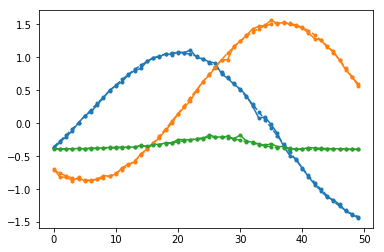

In [70]:
i=np.random.randint(test_Rossler_fast.shape[0]-(input_length+output_length))
x_test = test_Rossler_fast[i:i+input_length+output_length,:]
y_test = x_test[-(output_length):,:]
x_test = x_test[:-output_length,:]
y_pred = predictor.predict(np.expand_dims(x_test,axis=0)).squeeze()

plt.plot(range(output_length),y_pred.squeeze(),'.-');
plt.gca().set_prop_cycle(None);
plt.plot(range(output_length), y_test,'.--');